In [1]:
import pygame
import sys
import time
import random

import pygame.locals as pgl

import numpy as np

import networkx as nx
import epydemic

from custom_disease_model import Kennels, DistemperModel
# from aggregate_visualization import AggregatePlot

from copy import copy, deepcopy

from threading import Thread

import logging

import multiprocessing
from multiprocessing import Pool

import tqdm

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from matplotlib import cm

from interventions import SortIntervention

class Simulation(object):
    
    def __init__(self, params, spatial_visualization=True, aggregate_visualization=True, return_on_equillibrium=False):
        self.return_on_equillibrium = return_on_equillibrium
        self.spatial_visualization = spatial_visualization
        self.aggregate_visualization = aggregate_visualization

        if not self.spatial_visualization and not self.aggregate_visualization and not self.return_on_equillibrium:
            logging.warning('Warning: No visualizations were set, it is highly recommended you set return_on_equillibrium to True otherwise you will have to manually manage the simulation state.')

        self.params = params
        if 'infection_kernel_function' in self.params and type(self.params['infection_kernel_function']) == str:
            self.params['infection_kernel_function'] = eval(self.params['infection_kernel_function'])
        else:
            self.params['infection_kernel_function'] = lambda node, k: 0.0
        if 'intervention' in self.params and type(self.params['intervention']) == str:
            self.params['intervention'] = eval(self.params['intervention'])
        else:
            self.params['intervention'] = None
        self.kennels = Kennels()
        self.disease = DistemperModel(self.kennels.get_graph(), self.params)

        self.update_hooks = []

#         if spatial_visualization:
#             self.FPS = 0
#             self.SCREEN_WIDTH, self.SCREEN_HEIGHT = 640, 480
#             pygame.init()
#             self.fpsClock = pygame.time.Clock()
#             self.screen = pygame.display.set_mode((self.SCREEN_WIDTH, self.SCREEN_HEIGHT), 0, 32)
#             self.surface = pygame.Surface(self.screen.get_size())
#             self.surface = self.surface.convert()
#             self.surface.fill((255,255,255))
#             self.clock = pygame.time.Clock()

#             pygame.key.set_repeat(1, 40)
        
#             self.screen.blit(self.surface, (0,0))

#             self.font = pygame.font.Font(None, 36)
        
#         if aggregate_visualization:
#             self.plt = AggregatePlot(self.disease, self.kennels)
#             self.update_hooks.append(self.plt.update)

    def check_events(self):
        for event in pygame.event.get():
            if event.type == pgl.QUIT:
                pygame.quit()
                sys.exit()
            elif event.type == pgl.KEYDOWN:
                if event.key == pgl.K_ESCAPE:
                    pygame.quit()
                    sys.exit()

    def redraw(self):
        self.screen.blit(self.surface, (0,0))
        pygame.display.flip()
        pygame.display.update()
        self.fpsClock.tick(self.FPS)

    def draw_ui(self):
        text = self.font.render('{0} days, {1} hours'.format(int(np.floor(self.disease.t/24.0)), self.disease.t%24), 1, (10, 10, 10))
        textpos = text.get_rect()
        textpos.centerx = 200
        self.surface.blit(text, textpos)

    def get_disease_state(self):
        return {sc: len(self.disease.get_state_node(sc)['members']) for sc in self.disease.id_map.keys()}
        
    def update(self):
        if self.spatial_visualization:
            self.check_events()
            self.surface.fill((255,255,255))

        if not self.disease.in_equilibrium():
            if 'intervention' in self.params and self.params['intervention'] != None:
                self.params['intervention'].update(simulation=self)
            self.disease.update(self.kennels)
        elif self.return_on_equillibrium:
            self.running = False
            return

        for hook in self.update_hooks:
            print(hook)
            hook()
        
        if self.spatial_visualization:
            self.kennels.draw(self.surface, self.disease)
            self.draw_ui()
            self.redraw()
    
    def stop(self):
        self.running = False

    def run(self, asynchronous=False):
        self.running = True
        if asynchronous:
            self.async_thread = Thread(target=self.run, args=(False,))
            self.async_thread.start()
        else:
            while self.running:
                self.update()
            return self.get_disease_state()

class BatchSimulation(object):
    def __init__(self, params, runs, pool_size=-1):
        self.params = params
        self.runs = runs
        if pool_size == None:
            self.pool_size = 1
        elif pool_size <= 0:
            self.pool_size = multiprocessing.cpu_count()
        
    def run(self):
        results = []
        with Pool(self.pool_size) as p:
            for i in tqdm.tqdm(p.imap_unordered(BatchSimulation.run_simulation, [deepcopy(self.params) for _ in range(0, self.runs)]), total=self.runs):
                results.append(i)
            p.close()
            p.join()
        return results
            
    @staticmethod
    def run_simulation(params):
        return Simulation(params, spatial_visualization=False, aggregate_visualization=False, return_on_equillibrium=True).run()

def main(batch=False):
    params = {
            'pIntake': 0.25,
            'pInfect': 0.04,
            'pSurvive': 0.0025,
            'pDie': 0.0058333333333333,
            'pDieAlternate': 0.0,
            'refractoryPeriod': 3.0*24.0,
            'infection_kernel': [0.5, 0.25],
            'infection_kernel_function': 'lambda node, k: k*(1-node[\'occupant\'][\'immunity\'])',
            'immunity_growth_factors': [1.03, 0.001], # _[0]*immunity+_[1]
            'intervention': 'SortIntervention()'
        }
    if not batch:
        sim = Simulation(params, spatial_visualization=True, return_on_equillibrium=False, aggregate_visualization=False)
#         print(sim.run())
    else:
        runs = 32
        bar_width = 0.35
        proportion = True
        colors = [cm.jet(0), cm.jet(0.5)]
        alphas = [0.5, 0.25]
        labels = ['Sort Intervention', 'No Intervention']
        
        params1 = copy(params)
        params1['intervention'] = None
        
        results = BatchSimulation(params, runs).run()

        total = sum(list(results[0].values()))
        df = pd.DataFrame.from_records(results)
        if proportion:
            df /= total
        
        plt.rcdefaults()

        objects = df.columns
        y_pos = np.arange(len(objects))
        
        plt.bar(y_pos-bar_width/2, df.mean(), bar_width, align='center', alpha=alphas[0], yerr=df.std()/np.sqrt(len(df)), color=colors[0], label=labels[0])
        
        results = BatchSimulation(params1, runs).run()
        df = pd.DataFrame.from_records(results)
        if proportion:
            df /= total
        plt.bar(y_pos+bar_width/2, df.mean(), bar_width, align='center', alpha=alphas[1], yerr=df.std()/np.sqrt(len(df)), color=colors[1], label=labels[1])

        plt.xticks(y_pos, objects)
        plt.ylabel('Mean Animal Count')
        plt.ylim(0, 1)
        plt.title('Average Simulation Performance')
        plt.legend()

        plt.show()
    

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
params = {
        'pIntake': 0.25,
        'pInfect': 0.04,
        'pSurvive': 0.0025,
        'pDie': 0.0058333333333333,
        'pDieAlternate': 0.0,
        'refractoryPeriod': 3.0*24.0,
        'infection_kernel': [0.5, 0.25],
        'infection_kernel_function': 'lambda node, k: k*(1-node[\'occupant\'][\'immunity\'])',
        'immunity_growth_factors': [1.03, 0.001], # _[0]*immunity+_[1]
        'intervention': 'SortIntervention()'
    }
sim = Simulation(params, spatial_visualization=False, aggregate_visualization=False, return_on_equillibrium=True)

In [3]:
sim.get_disease_state()

{'D': 0, 'E': 96, 'I': 0, 'IS': 0, 'S': 0}

In [57]:
start = time.time()
try:
    del(df_tmp,df_concat)
except:
    None
for idx in range(50):
    sim = Simulation(params, spatial_visualization=False, aggregate_visualization=False, return_on_equillibrium=True)
    df_tmp = pd.DataFrame(sim.get_disease_state(),index=[0])
    for simul_time in range(1,25):
        sim.update()
        tmp = pd.DataFrame(sim.get_disease_state(),index=[simul_time])
        df_tmp = df_tmp.append(tmp)
    try:
        df_concat = pd.concat((df_tmp,df_concat))
    except:
        df_concat = df_tmp
        
end = time.time()
print("Elapsed Time: ",end-start)

Elapsed Time:  25.531286478042603


In [58]:
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
df_std = by_row_index.std()

/mnt/c/Users/Awesome/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


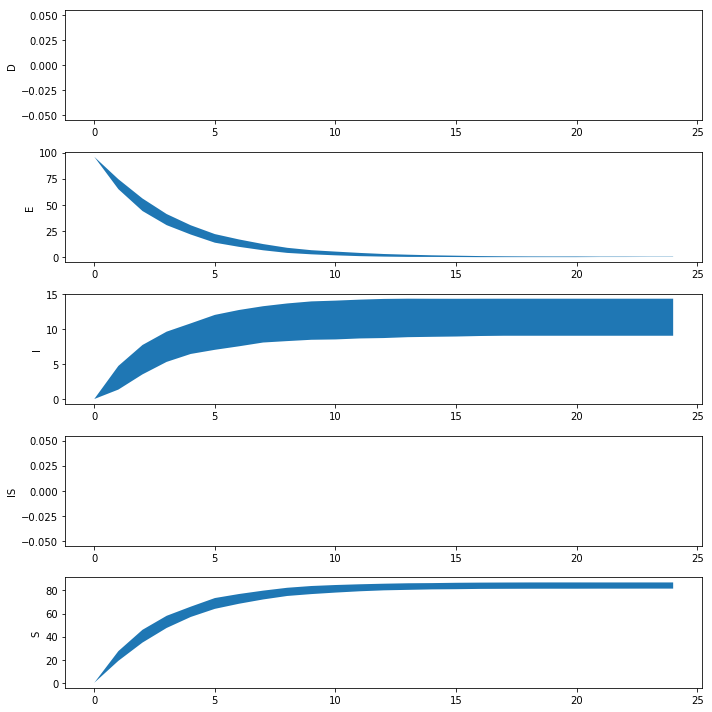

In [69]:
Fig, ax = plt.subplots(5,figsize = (10,10))
x = np.array(df_means.index)
y = np.array(df_means['E'])
for idx,col in enumerate(df_means.columns):
    y_low = df_means[col] - df_std[col]
    y_high = df_means[col] + df_std[col]
    ax[idx].fill_between(x,y_low,y_high)
    ax[idx].set_ylabel(col)
Fig.set_tight_layout('tight')

In [68]:
df_means.tail()

,D,E,I,IS,S
20,0.0,0.06,11.68,0.0,84.26
21,0.0,0.04,11.68,0.0,84.28
22,0.0,0.04,11.68,0.0,84.28
23,0.0,0.02,11.68,0.0,84.30
24,0.0,0.02,11.68,0.0,84.30


In [65]:
df_std.head()

,D,E,I,IS,S
0,0.0,0.000000,0.000000,0.0,0.000000
1,0.0,4.776815,1.689825,0.0,4.211549
2,0.0,6.015253,2.098493,0.0,5.540206
3,0.0,5.328246,2.159081,0.0,5.273306
4,0.0,4.440123,2.184267,0.0,4.464097


In [9]:
# Create dataframe to hold simulation data
df2 = pd.DataFrame(sim.get_disease_state(),index=['sort_0'])
for time in range(1,100):
    sim.update()
    tmp = pd.DataFrame(sim.get_disease_state(),index=['sort_'+str(time)])
    df2 = df2.append(tmp)
df2.head()

,D,E,I,IS,S
-1,8,0,9,79,0
sort_0,8,0,9,79,0
sort_1,8,0,9,79,0
sort_2,8,0,9,79,0
sort_3,8,0,9,79,0
sort_4,8,0,9,79,0
sort_5,8,0,9,79,0
sort_6,8,0,9,79,0
sort_7,8,0,9,79,0
sort_8,8,0,9,79,0


In [46]:
df = pd.DataFrame(data,index=[0])
df

,D,E,I,IS,S
0,13,0,7,76,0


In [39]:
id_map = {'E': 0, 'S': 1, 'IS': 2, 'I': 3, 'D': 4}

In [43]:
all_nodes = [int(node) for node in beta.nodes]

TypeError: 'method' object is not iterable

In [2]:
state_graph = nx.DiGraph()

all_nodes = [int(node) for node in state_graph.nodes]

In [14]:
state_graph.nodes()

[]